## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [6]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [5]:
!pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 217.9 kB/s eta 0:04:21
   ---------------------------------------- 0.1/56.8 MB 409.6 kB/s eta 0:02:19
   ---------------------------------------- 0.2/56.8 MB 1.0 MB/s eta 0:00:55
   ---------------------------------------- 0.3/56.8 MB 1.7 MB/s eta 0:00:34
   ---------------------------------------- 0.5/56.8 MB 2.0 MB/s eta 0:00:29
   ---------------------------------------- 0.5/56.8 MB 1.5 MB/s eta 0:00:38
   ---------------------------------------- 0.5/56.8 MB 1.6 MB/s eta 0:00:36
   ---------------------------------------- 0.5/56.8 MB 1.6 MB/s eta 0:00:36
   ---------------------------------------- 0.5/56.8 MB 1.6 MB/s eta 0:00:36
   ---------------------------------------- 0.5/56.8 MB 1.1 MB/s eta 0:00:50
    ------------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import the CSV Data as Pandas DataFrame

In [7]:
df = pd.read_csv('StudentsPerformance.csv')

#### Show Top 5 Records

In [8]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [10]:
df.duplicated().sum()

np.int64(0)

#### Preparing X and Y variables

In [11]:
X = df.drop(columns=['math score'],axis=1)

In [8]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [12]:
y = df['math score']

In [10]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

In [13]:
X.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
reading score                  72
writing score                  77
dtype: int64

#### Feature Distributions

#### check skewness of (reading_score,writing_score) data
- if data is not normally distributed or skewness is higher , consider transormations like : Log Transformation,Square Root Transformation...

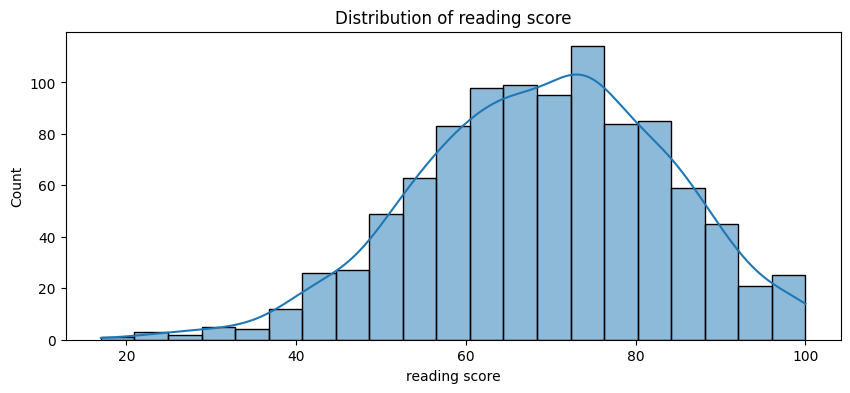

Skewness of reading score : -0.25910451810923063


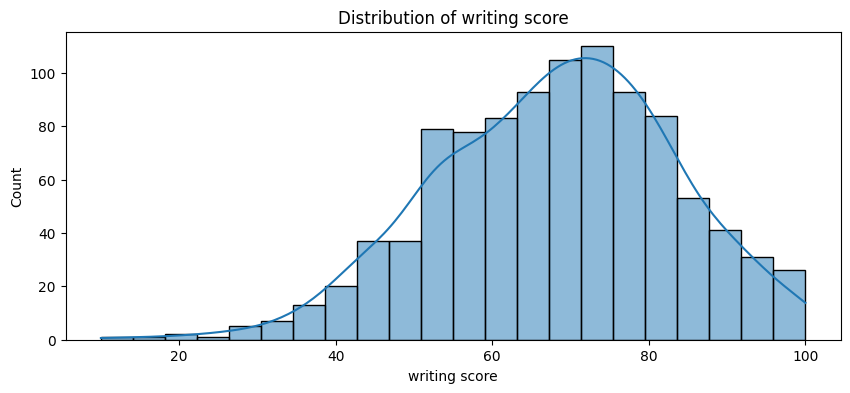

Skewness of writing score : -0.28944397150761897


In [14]:
num_col = ['reading score','writing score']

for col in num_col:
    plt.figure(figsize=(10, 4))
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    print(f"Skewness of {col} : {df[col].skew()}") 



#### Conclusion
- Both skewness is closer to zero: no need for transformation

#### Handling Categorical Columns

Handling Categorical values in parental_level_of_education column Using Map


In [15]:
# Get the unique values from the 'parental_level_of_education' column
parental_level_of_education_values = list(X['parental level of education'].value_counts().index)

# Initialize the mapping dictionary
education_mapping = {}

# Create the mapping dictionary
for n, i in enumerate(parental_level_of_education_values):
    education_mapping[i] = n


# Apply the mapping
X['parental level of education'] = X['parental level of education'].map(education_mapping)


In [16]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,4,standard,none,72,74
1,female,group C,0,standard,completed,90,88
2,female,group B,5,standard,none,95,93
3,male,group A,1,free/reduced,none,57,44
4,male,group C,0,standard,none,78,75


In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_features = ['reading score', 'writing score']
cat_features = ['gender', 'race/ethnicity', 'lunch', 'test preparation course']

oh_transformer = OneHotEncoder(drop='first')  # drop='first' to avoid dummy variable trap
numeric_transformer = StandardScaler()

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", oh_transformer, cat_features),
        ("scaler", numeric_transformer, num_features)
    ]
)

# Fit and transform the data
X = preprocessor.fit_transform(X)

In [170]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 9), (200, 9))

#### Create an Evaluate Function to give all metrics after model Training

In [171]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [173]:
models = {
    "Linear_Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_test_list = []
r2_train_list = []

for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
     # Evaluate Train and Test datasets
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Print performance
    print(f"{name} Performance:")
    print(f"Train -> RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
    print(f"Test  -> RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    print("="*40)
    
    # Append model name and test R2 score to lists
    model_list.append(name)
    r2_train_list.append(train_r2)
    r2_test_list.append(test_r2)

Linear_Regression Performance:
Train -> RMSE: 5.3695, MAE: 4.3076, R2: 0.8721
Test  -> RMSE: 5.3918, MAE: 4.1976, R2: 0.8805
Lasso Performance:
Train -> RMSE: 6.5938, MAE: 5.2063, R2: 0.8071
Test  -> RMSE: 6.5197, MAE: 5.1579, R2: 0.8253
Ridge Performance:
Train -> RMSE: 5.3699, MAE: 4.3073, R2: 0.8721
Test  -> RMSE: 5.3918, MAE: 4.1985, R2: 0.8805
K-Neighbors Regressor Performance:
Train -> RMSE: 5.2803, MAE: 4.2220, R2: 0.8763
Test  -> RMSE: 6.6372, MAE: 5.2870, R2: 0.8190
Decision Tree Performance:
Train -> RMSE: 0.6798, MAE: 0.1167, R2: 0.9980
Test  -> RMSE: 7.8576, MAE: 6.1650, R2: 0.7463
Random Forest Regressor Performance:
Train -> RMSE: 2.3518, MAE: 1.8897, R2: 0.9755
Test  -> RMSE: 6.0373, MAE: 4.6948, R2: 0.8502
XGBRegressor Performance:
Train -> RMSE: 1.4925, MAE: 1.0216, R2: 0.9901
Test  -> RMSE: 6.4311, MAE: 5.0179, R2: 0.8300
CatBoosting Regressor Performance:
Train -> RMSE: 3.6089, MAE: 2.8726, R2: 0.9422
Test  -> RMSE: 6.0010, MAE: 4.5787, R2: 0.8520
AdaBoost Regressor 

### Results

In [174]:
# Create DataFrame to summarize the results
model_results_df = pd.DataFrame(list(zip(model_list, r2_train_list,r2_test_list)), columns=['Model Name', 'Train_R2_Score','Test_R2_Score'])
model_results_df

,Model Name,Train_R2_Score,Test_R2_Score
0,Linear_Regression,0.872114,0.880530
1,Lasso,0.807146,0.825320
2,Ridge,0.872097,0.880529
3,K-Neighbors Regressor,0.876329,0.818967
4,Decision Tree,0.997950,0.746269
5,Random Forest Regressor,0.975467,0.850215
6,XGBRegressor,0.990119,0.830036
7,CatBoosting Regressor,0.942231,0.852009
8,AdaBoost Regressor,0.846244,0.844986


#### Conclusion
-  Decision Tree shows significant overfitting and should be avoided.
- Ridge and Linear Regression generalize well with minimal overfitting and are good choices for simpler models.

## Linear Regression

In [175]:
lin_model = LinearRegression()
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.05


### Plot y_pred and y_test

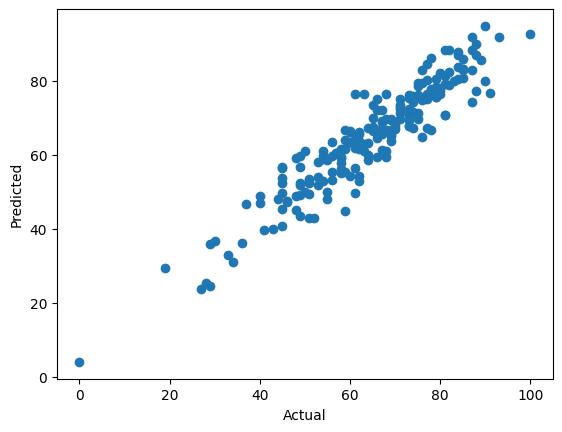

In [177]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

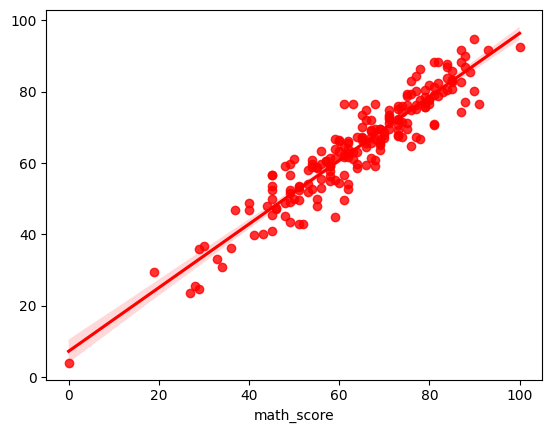

In [178]:
sns.regplot(x=y_test,y=y_pred,color ='red');

#### Difference between Actual and Predicted Values

In [179]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.646683,14.353317
737,53,58.034628,-5.034628
740,80,78.046320,1.953680
660,74,76.033605,-2.033605
411,84,87.014117,-3.014117
...,...,...,...
408,52,43.011668,8.988332
332,62,62.765402,-0.765402
208,74,67.186798,6.813202
613,65,67.415090,-2.415090


### Improve Model Performance
#### Hyperparameter Tuning with GridSearchCV

Using Ridge Regression

In [183]:
from sklearn.model_selection import GridSearchCV
# Define parameter grids for Ridge and Lasso
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV for Ridge
ridge_grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid_ridge, cv=5, scoring='r2')
ridge_grid_search.fit(X_train, y_train)

best_ridge_model = ridge_grid_search.best_estimator_

# Make prediction
y_train_pred_ridge = best_ridge_model.predict(X_train)
y_test_pred_ridge = best_ridge_model.predict(X_test)

print(f"Best Ridge Alpha: {ridge_grid_search.best_params_['alpha']}")
print(f"Ridge Train R2 Score: {r2_score(y_train, y_train_pred_ridge)}")
print(f"Ridge Test R2 Score: {r2_score(y_test, y_test_pred_ridge)}")


Best Ridge Alpha: 0.1
Ridge Train R2 Score: 0.872113835336834
Ridge Test R2 Score: 0.8805314322310962


Using Lasso

In [185]:
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}

lasso_grid_search = GridSearchCV(estimator=Lasso(), param_grid=param_grid_lasso, cv=5, scoring='r2')
lasso_grid_search.fit(X_train, y_train)

best_lasso_model = lasso_grid_search.best_estimator_
y_train_pred_lasso = best_lasso_model.predict(X_train)
y_test_pred_lasso = best_lasso_model.predict(X_test)
print(f"Best Lasso Alpha: {lasso_grid_search.best_params_['alpha']}")
print(f"Lasso Train R2 Score: {r2_score(y_train, y_train_pred_lasso)}")
print(f"Lasso Test R2 Score: {r2_score(y_test, y_test_pred_lasso)}")

Best Lasso Alpha: 0.01
Lasso Train R2 Score: 0.872095333537661
Lasso Test R2 Score: 0.8808378726492039


Before Hyperparameter Tuning

In [186]:
model_results_df.head(3)

,Model Name,Train_R2_Score,Test_R2_Score
0,Linear_Regression,0.872114,0.880530
1,Lasso,0.807146,0.825320
2,Ridge,0.872097,0.880529


After Hyperparameter Tuning

Ridge 

-Ridge Train R2 Score: 0.872113835336834

-Ridge Test R2 Score: 0.8805314322310962

Lasso

-Lasso Train R2 Score: 0.872095333537661

-Lasso Test R2 Score: 0.8808378726492039

Conclusion:
- Linear , Ridge , Lasso performing similar